## Unified version

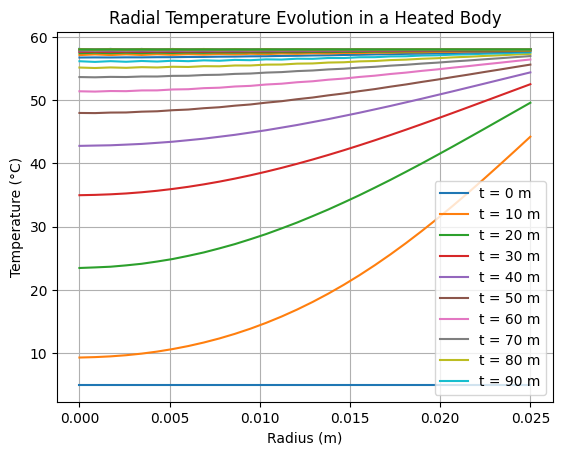

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
Thickness = 50e-3  # Thickness of the meat in the larger point in the meat (in m)
Beta = 1.0      # Coefficient for the geometry term (set to 0 for slab, 1 for cylinder and 2 for sphere, 1.25 for cube)
T_fluid = 58.0  # Fluid temperature in °C
T_initial = 5.0  # Initial temperature of the cylinder in °C
simulation_hours = 7  # Simulation time in hours
alpha = 1.11e-7  # Thermal diffusivity in m^2/s (example for steel)
k = 0.48         # Thermal conductivity in W/(m·K) (Sanz et al., thermal conductivity of beef)
h = 95          # Convective heat transfer coefficient in W/(m^2·K)
N = 30          # Number of radial points
R = Thickness / 2  # Radius of the cylinder (10 cm diameter = 0.05 m radius)
t_max = 3600*simulation_hours # Maximum simulation time in seconds
dt = 60         # Time step in seconds

dr = R / (N - 1)  # Radial step size
r = np.linspace(0, R, N)  # Radial points from 0 to R
t = np.linspace(0, t_max, int(t_max/dt)+1)  # Time points

# Define the heat equation with convective boundary conditions
def heat_equation(t, T):
    dTdt = np.zeros_like(T)
    
    # Symmetry condition at r = 0
    #dTdt[0] = alpha * (T[1] - T[0]) / dr**2
    dTdt[0] = alpha * (2 / dr**2) * (T[1] - T[0])

    # Interior points
    for i in range(1, N - 1):
        d2T_dr2 = (T[i+1] - 2*T[i] + T[i-1]) / dr**2
        radial_term = (Beta / r[i]) * (T[i+1] - T[i-1]) / (2 * dr) if r[i] != 0 else 0
        dTdt[i] = alpha * (d2T_dr2 + radial_term)
    
    # Convective boundary condition at the outer radius
    dTdt[-1] = alpha * (1 / dr**2) * (T[-2] - T[-1] - (dr * h / k) * (T[-1] - T_fluid))
    
    return dTdt

# Solve the PDE using SciPy's solve_ivp
solution = solve_ivp(
    heat_equation,                 # ODE function
    (0, t_max),                    # Time range
    np.full(N, T_initial),         # Initial condition (uniform temperature)
    method='RK45',                 # Solver
    t_eval=t                       # Time points to evaluate
)

# Extract the solution
T_sol = solution.y
time_points = solution.t

# Plot the results
for i in range(0, len(time_points), 10):  # Plot every 20th time point
    plt.plot(r, T_sol[:, i], label=f"t = {(time_points[i])/60:.0f} m" if i <100 else None)

plt.xlabel("Radius (m)")
plt.ylabel("Temperature (°C)")
plt.title("Radial Temperature Evolution in a Heated Body")
plt.legend()
plt.grid()


The center reaches -0.5°C of the final temperature at approximately 2h:2m


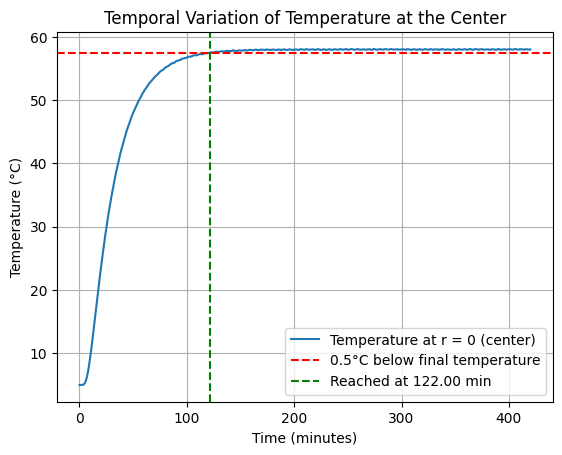

In [3]:
# Extract the temperature at the center of the cylinder (r = 0)
center_temperature = T_sol[0, :]  # First row corresponds to T[0] (r = 0)
time_points_minutes = time_points / 60  # Convert seconds to minutes

# Define 99% of the final temperature
final_temperature = T_fluid  # The final temperature is the fluid temperature
threshold_temperature = T_fluid - 0.5 #T_initial + 0.996 * (T_fluid - T_initial)   # 99% of the final temperature

# Find the first time where the center temperature exceeds the threshold
minute_reached = None
for i, temp in enumerate(center_temperature):
    if temp >= threshold_temperature:
        minute_reached = time_points_minutes[i]
        break

# Display the result
if minute_reached is not None:
    print(f"The center reaches -0.5°C of the final temperature at approximately {int(minute_reached)//60}h:{int(minute_reached)%60}m")
else:
    print("The center does not reach 99% of the final temperature within the simulated time.")

# Optional: Mark the point on the plot
plt.plot(time_points_minutes, center_temperature, label="Temperature at r = 0 (center)")
plt.axhline(threshold_temperature, color='r', linestyle='--', label="0.5°C below final temperature")
if minute_reached is not None:
    plt.axvline(minute_reached, color='g', linestyle='--', label=f"Reached at {minute_reached:.2f} min")
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Temporal Variation of Temperature at the Center")
plt.legend()
plt.grid()
plt.show()

In [75]:
Dref = 2/6 # 2 minutes for 6-log reduction
Tref = 70 # Reference temperature in °C
z = 7.5 # Z-value in °C

# Initialize the cumulative total_sum array
cumulative_sum = []

# Initialize the running sum
total_sum = 0

# Loop through each temperature and calculate the contribution
for T_i in center_temperature:
    contribution = 10 ** ((T_i - Tref) / z)
    total_sum += (1/Dref) * contribution
    cumulative_sum.append(total_sum)  # Add the current total_sum to the array

# Calculate the final LR
LR = total_sum


In [4]:
from models.solvers import LogReduction
LR, cumulative_sum = LogReduction(center_temperature)

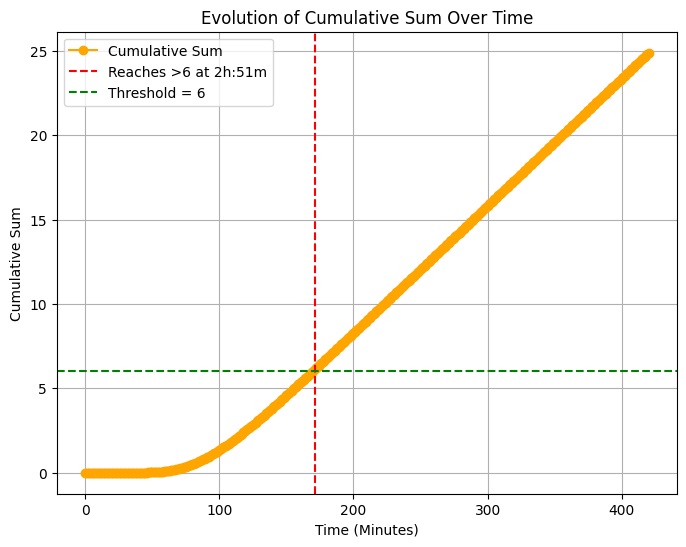

In [5]:
# Identify the point where cumulative sum exceeds 6
threshold = 6
time_to_exceed = next((i for i, value in enumerate(cumulative_sum) if value > threshold), None)

# Plot the cumulative sum evolution
plt.figure(figsize=(8, 6))
plt.plot(time_points_minutes, cumulative_sum, marker='o', label='Cumulative Sum', color='orange')
if time_to_exceed is not None:
    plt.axvline(x=time_to_exceed + 1, color='red', linestyle='--', label=f'Reaches >6 at {(time_to_exceed + 1) // 60}h:{(time_to_exceed+1)%60}m')
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold = 6')
plt.title("Evolution of Cumulative Sum Over Time")
plt.xlabel("Time (Minutes)")
plt.ylabel("Cumulative Sum")
plt.legend()
plt.grid(True)
plt.show()

## Test packages

In [1]:
from models.parameters import MeatSimulationParameters
from models.solvers import SimulateMeat

In [2]:
msp = MeatSimulationParameters()

In [4]:
msp.Thickness

0.05

In [7]:
SimulateMeat(msp)

(array([[ 5.        ,  4.99999971,  5.000371  , ..., 58.00943402,
         57.97726566, 58.0140958 ],
        [ 5.        ,  5.00000043,  4.99995637, ..., 57.99059254,
         58.02265483, 57.98594653],
        [ 5.        ,  4.99999935,  5.00057405, ..., 58.00935105,
         57.97746558, 58.01397183],
        ...,
        [ 5.        , 15.57609286, 22.19150787, ..., 57.9989434 ,
         58.00254289, 57.99842186],
        [ 5.        , 19.59032191, 26.03802138, ..., 58.00063447,
         57.9984694 , 58.00094827],
        [ 5.        , 24.42249333, 30.27659608, ..., 57.99977446,
         58.00054149, 57.99966335]], shape=(30, 421)),
 array([    0.,    60.,   120.,   180.,   240.,   300.,   360.,   420.,
          480.,   540.,   600.,   660.,   720.,   780.,   840.,   900.,
          960.,  1020.,  1080.,  1140.,  1200.,  1260.,  1320.,  1380.,
         1440.,  1500.,  1560.,  1620.,  1680.,  1740.,  1800.,  1860.,
         1920.,  1980.,  2040.,  2100.,  2160.,  2220.,  2280.,  234